In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'            
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

### Load sales data

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO014800346,93,2018-11-01 17:35:45.707,1682,Kurundugaha Medical,Southern Province,Galle,Karandeniya,148,Dinesh Rasanga De Zoysa,15,Unique Enterprises,240,nitroimidazoles GEL 30mg,3.0,233.4,266.0,0.0,0.0,700.2,2018,November,11,1,5,Thursday,17
1,CSO007901565,53,2018-11-02 15:55:54.477,245,DUNAGAHA OSUSALA,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,206,Solmux Forte Susp. 60ml,6.0,477.3,544.0,0.0,0.0,2863.8,2018,November,11,2,6,Friday,15
2,CSO011701386,54,2018-11-02 15:57:09.090,367,JAYASIRI PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,5,Benzoyl Peroxide,2.0,405.4,462.0,0.0,0.0,810.8,2018,November,11,2,6,Friday,15
3,IN0066000110,0,2018-11-02 16:04:38.987,4032,Union Dispensary,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,240,nitroimidazoles GEL 30mg,6.0,233.4,266.0,0.0,0.0,1400.4,2018,November,11,2,6,Friday,16
4,IN0066000110,0,2018-11-02 16:04:38.987,4032,Union Dispensary,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,257,Unimelo Tab 7.5mg-100's,10.0,596.5,680.0,0.0,0.0,5965.0,2018,November,11,2,6,Friday,16


### What is the best date of week for sales?

In [6]:
#group data
Week_Sales = invoice_All.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,4.351611e+07
1,2,Monday,5.356381e+08
2,3,Tuesday,5.522812e+08
3,4,Wednesday,5.036746e+08
4,5,Thursday,6.061361e+08
5,6,Friday,5.941643e+08
6,7,Saturday,3.611790e+08


In [7]:
#group data
Week_invoices = invoice_All.groupby("WeekDay")['ID'].nunique().reset_index()
Week_invoices = Week_invoices.set_index("WeekDay")
Week_invoices.sort_index(inplace=True)
Week_invoices.reset_index()

,WeekDay,ID
0,1,2499
1,2,34923
2,3,32900
3,4,32399
4,5,35821
5,6,34187
6,7,22281


In [8]:
Week_Sales_summary = pd.merge(Week_Sales,Week_invoices,  how = 'left' , left_on = ['WeekDay']  , right_on = ['WeekDay']).reset_index()
Week_Sales_summary.rename(columns={'ID':'NubOfInvoices'}, inplace=True)
Week_Sales_summary["AverageRevenue"] = Week_Sales_summary["GrossValue"] / Week_Sales_summary["NubOfInvoices"]
Week_Sales_summary = Week_Sales_summary.round({'AverageRevenue': 1})

In [9]:
Week_Sales_summary.head(7)

,WeekDay,DateName,GrossValue,NubOfInvoices,AverageRevenue
0,1,Sunday,4.351611e+07,2499,17413.4
1,2,Monday,5.356381e+08,34923,15337.7
2,3,Tuesday,5.522812e+08,32900,16786.7
3,4,Wednesday,5.036746e+08,32399,15546.0
4,5,Thursday,6.061361e+08,35821,16921.3
5,6,Friday,5.941643e+08,34187,17379.8
6,7,Saturday,3.611790e+08,22281,16210.2


### Analysis for total sales invoices - Head office / Distributor and sales representative

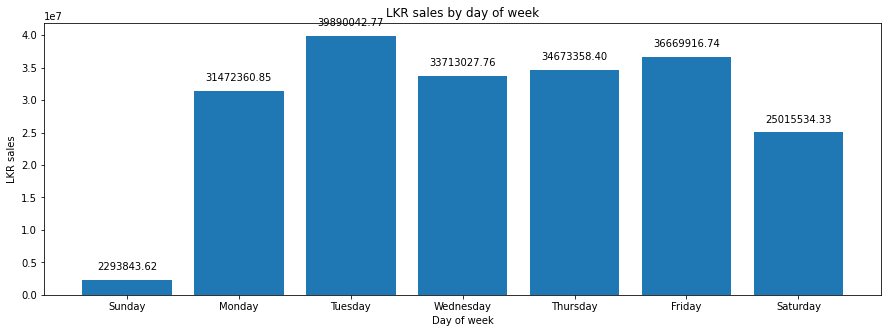

In [59]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("LKR sales by day of week")
plt.rcParams['figure.figsize'] = [15, 5]

# zip joins x and y coordinates in pairs
for x,y in zip(Week_Sales.DateName,Week_Sales.GrossValue):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

### Discussion Points

* Above is same figure without any modification.
* Since we capture direct sales from head office and distributor, this would lead to many outliers with sales amount. 
* So decided to look it to sales representative sales separately.

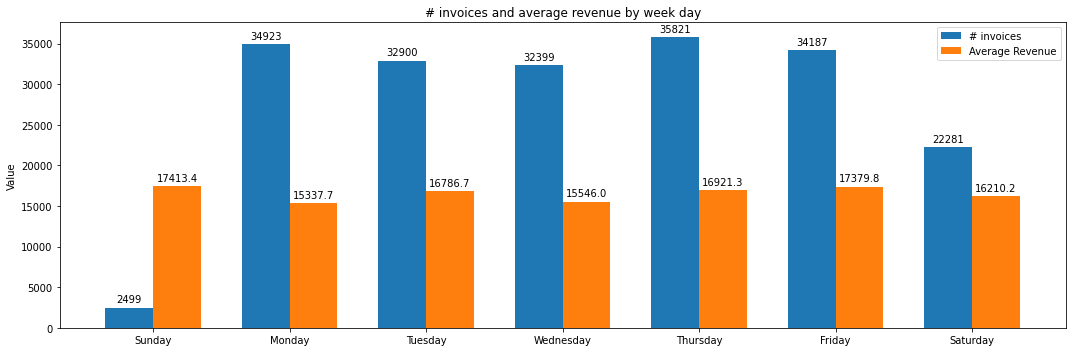

In [11]:
x = np.arange(len(Week_Sales_summary.DateName))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Week_Sales_summary.NubOfInvoices, width, label='# invoices')
rects2 = ax.bar(x + width/2, Week_Sales_summary.AverageRevenue, width, label='Average Revenue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('# invoices and average revenue by week day')
ax.set_xticks(x)
ax.set_xticklabels(Week_Sales_summary.DateName)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Discussion Points

* For the same data set try to identify number of invoices and average revenue per invoice
* Highest number of invoices were placed on Thursday and lowest were in Sunday
* Highest average revenue per invoice were recorded on Sunday although fewer number of invoices created
* Friday has the next highest average revenue. (but this could be due to few outliers)

### Analysis for total sales invoices -  sales representative

In [12]:
# select only rep sales records 
Rep_invoice_All = invoice_All.loc[invoice_All['SiteUID'] != 0]

In [13]:
Rep_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO014800346,93,2018-11-01 17:35:45.707,1682,Kurundugaha Medical,Southern Province,Galle,Karandeniya,148,Dinesh Rasanga De Zoysa,15,Unique Enterprises,240,nitroimidazoles GEL 30mg,3.0,233.4,266.0,0.0,0.0,700.2,2018,November,11,1,5,Thursday,17
1,CSO007901565,53,2018-11-02 15:55:54.477,245,DUNAGAHA OSUSALA,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,206,Solmux Forte Susp. 60ml,6.0,477.3,544.0,0.0,0.0,2863.8,2018,November,11,2,6,Friday,15
2,CSO011701386,54,2018-11-02 15:57:09.090,367,JAYASIRI PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,5,Benzoyl Peroxide,2.0,405.4,462.0,0.0,0.0,810.8,2018,November,11,2,6,Friday,15
7,CSO011701389,54,2018-11-02 15:59:37.587,365,CHRISHANTHAS PHARMACY,North Western Province,Puttalam,MARAWILA,117,,2,The West Central Pharma (Pvt) Ltd.,105,Thermoseal Floss 50M,1.0,285.1,325.0,0.0,0.0,285.1,2018,November,11,2,6,Friday,15
8,CSO007901571,53,2018-11-05 07:53:42.137,241,M.P.C.S OSUSALA,Western Province,Gampaha,DIVULAPITIYA,79,Shashikala perera,2,The West Central Pharma (Pvt) Ltd.,25,Aluminum hydroxide 240ml,5.0,238.7,272.0,0.0,0.0,1193.5,2018,November,11,5,2,Monday,7


In [14]:
#group data
Week_Sales = Rep_invoice_All.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,4.092203e+07
1,2,Monday,4.971670e+08
2,3,Tuesday,4.960276e+08
3,4,Wednesday,4.615735e+08
4,5,Thursday,5.568526e+08
5,6,Friday,5.442823e+08
6,7,Saturday,3.296735e+08


In [15]:
#group data
Week_invoices = Rep_invoice_All.groupby("WeekDay")['ID'].nunique().reset_index()
Week_invoices = Week_invoices.set_index("WeekDay")
Week_invoices.sort_index(inplace=True)
Week_invoices.reset_index()

,WeekDay,ID
0,1,2263
1,2,32130
2,3,29777
3,4,29635
4,5,32976
5,6,31167
6,7,20021


In [16]:
Week_Sales_summary = pd.merge(Week_Sales,Week_invoices,  how = 'left' , left_on = ['WeekDay']  , right_on = ['WeekDay']).reset_index()
Week_Sales_summary.rename(columns={'ID':'NubOfInvoices'}, inplace=True)
Week_Sales_summary["AverageRevenue"] = Week_Sales_summary["GrossValue"] / Week_Sales_summary["NubOfInvoices"]
Week_Sales_summary = Week_Sales_summary.round({'AverageRevenue': 1})

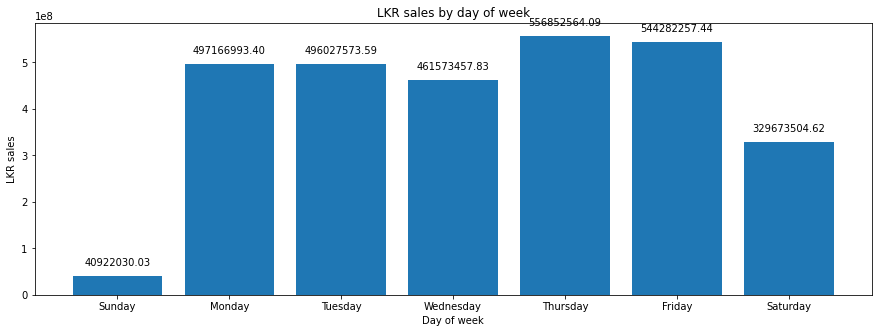

In [17]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("LKR sales by day of week")
plt.rcParams['figure.figsize'] = [15, 5]

# zip joins x and y coordinates in pairs
for x,y in zip(Week_Sales.DateName,Week_Sales.GrossValue):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

#### Discussion Points

* When only considering sales rep sales most sales day has change to Thursday
* This is also without removing any outliers

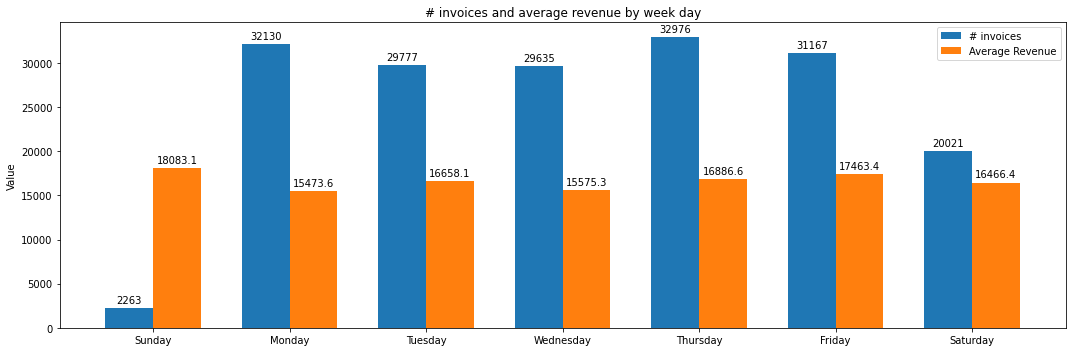

In [18]:
x = np.arange(len(Week_Sales_summary.DateName))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Week_Sales_summary.NubOfInvoices, width, label='# invoices')
rects2 = ax.bar(x + width/2, Week_Sales_summary.AverageRevenue, width, label='Average Revenue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('# invoices and average revenue by week day')
ax.set_xticks(x)
ax.set_xticklabels(Week_Sales_summary.DateName)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Discussion Points

* For the same data set (Sales rep only sales) try to identify number of invoices and average revenue per invoice
* Highest number of invoices were placed on Thursday and lowest were on Sunday
* Highest average revenue per invoice were recorded on Sunday although fewer number of invoices created
* Thursday has the next highest average revenue (only slight difference from Friday). (but this could be due to few outliers)

### Analysis for total sales invoices -  Head office and Distributor

In [19]:
# select only rep sales records 
Admin_invoice_All = invoice_All.loc[invoice_All['SiteUID'] == 0]

In [20]:
Admin_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
3,IN0066000110,0,2018-11-02 16:04:38.987,4032,Union Dispensary,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,240,nitroimidazoles GEL 30mg,6.0,233.4,266.0,0.0,0.0,1400.4,2018,November,11,2,6,Friday,16
4,IN0066000110,0,2018-11-02 16:04:38.987,4032,Union Dispensary,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,257,Unimelo Tab 7.5mg-100's,10.0,596.5,680.0,0.0,0.0,5965.0,2018,November,11,2,6,Friday,16
5,IN0066000110,0,2018-11-02 16:04:38.987,4032,Union Dispensary,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,257,Unimelo Tab 7.5mg-100's,0.0,658.0,750.0,1.0,1.0,0.0,2018,November,11,2,6,Friday,16
6,IN0066000129,0,2018-11-03 09:22:32.160,2526,Keerthi Pharmacy,Southern Province,Matara,Weligama,105,Chamara Abegunawardena,14,Unichemist Distributor,206,Solmux Forte Susp. 60ml,15.0,477.3,544.0,0.0,0.0,7159.5,2018,November,11,3,7,Saturday,9
11,IN0066000110,0,2018-11-02 16:04:38.987,4032,Union Dispensary,Southern Province,Matara,Matara,105,Chamara Abegunawardena,14,Unichemist Distributor,212,Tascit Tab 30's,6.0,736.9,840.0,0.0,0.0,4421.4,2018,November,11,2,6,Friday,16


In [21]:
#group data
Week_Sales = Admin_invoice_All.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,2594083.62
1,2,Monday,38471095.40
2,3,Tuesday,56253646.37
3,4,Wednesday,42101184.26
4,5,Thursday,49283544.15
5,6,Friday,49882013.94
6,7,Saturday,31505486.13


In [22]:
#group data
Week_invoices = Admin_invoice_All.groupby("WeekDay")['ID'].nunique().reset_index()
Week_invoices = Week_invoices.set_index("WeekDay")
Week_invoices.sort_index(inplace=True)
Week_invoices.reset_index()

,WeekDay,ID
0,1,236
1,2,2793
2,3,3123
3,4,2764
4,5,2845
5,6,3020
6,7,2260


In [23]:
Week_Sales_summary = pd.merge(Week_Sales,Week_invoices,  how = 'left' , left_on = ['WeekDay']  , right_on = ['WeekDay']).reset_index()
Week_Sales_summary.rename(columns={'ID':'NubOfInvoices'}, inplace=True)
Week_Sales_summary["AverageRevenue"] = Week_Sales_summary["GrossValue"] / Week_Sales_summary["NubOfInvoices"]
Week_Sales_summary = Week_Sales_summary.round({'AverageRevenue': 1})

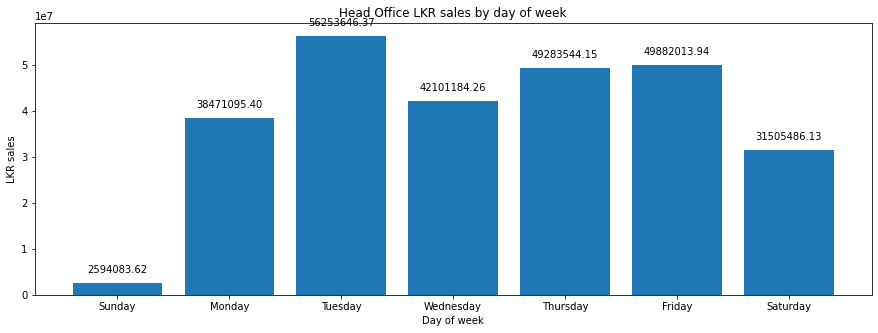

In [24]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("Head Office LKR sales by day of week")
plt.rcParams['figure.figsize'] = [15, 5]

# zip joins x and y coordinates in pairs
for x,y in zip(Week_Sales.DateName,Week_Sales.GrossValue):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

#### Discussion Points

* When only considering Head office and distributor sales Friday is the most selling date
* This is also without removing any outliers

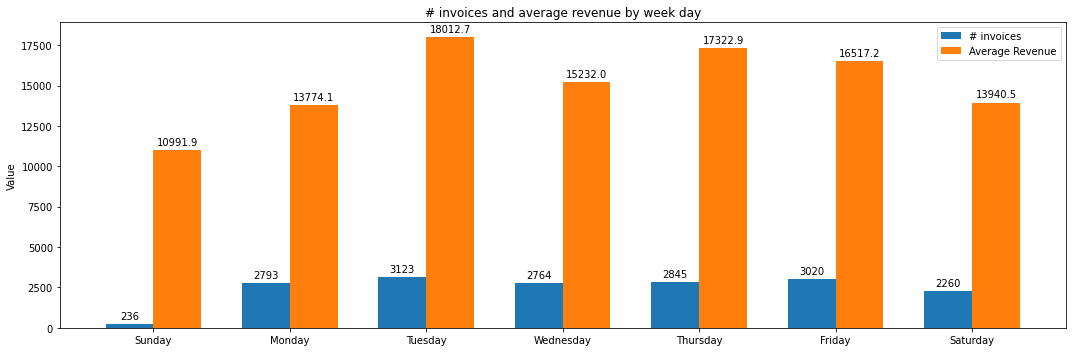

In [25]:
x = np.arange(len(Week_Sales_summary.DateName))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Week_Sales_summary.NubOfInvoices, width, label='# invoices')
rects2 = ax.bar(x + width/2, Week_Sales_summary.AverageRevenue, width, label='Average Revenue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('# invoices and average revenue by week day')
ax.set_xticks(x)
ax.set_xticklabels(Week_Sales_summary.DateName)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Discussion Points

* For the same data set (Head office and distributor) try to identify number of invoices and average revenue per invoice
* Highest number of invoices were placed on Tuesday (Slightly higher from Friday) and lowest were on Sunday
* Highest average revenue per invoice were recorded on Sunday although fewer number of invoices created - comparatively high revenue on those invoices
* Friday has the next highest average revenue

#### Discussion Points

* Both Scenarios Sunday had lowest number of invoices and Highest average revenue per invoice

## Check for Outliers

In [26]:
# Group data by invoice
Sale_by_invoice = invoice_All.groupby("ID").agg({'GrossValue':'sum' , 'DateName':'max' , 'WeekDay':'max' }).reset_index()
# setting WeekDay as index column
Sale_by_invoice = Sale_by_invoice.set_index("ID")
Sale_by_invoice.sort_index(inplace=True)
Sale_by_invoice.reset_index()

,ID,GrossValue,DateName,WeekDay
0,BO0081000081,711.0,Saturday,7
1,BO0081000107,5020.0,Tuesday,3
2,BO0081000146,1592.1,Tuesday,3
3,BO0081000147,3184.2,Tuesday,3
4,BO0081000148,7960.5,Tuesday,3
...,...,...,...,...
195005,IN0190000001,198425.6,Saturday,7
195006,IN0190000003,26797.5,Monday,2
195007,IN0190000005,18400.0,Wednesday,4
195008,IN0190000006,36766.0,Wednesday,4


### Total Sales by week day

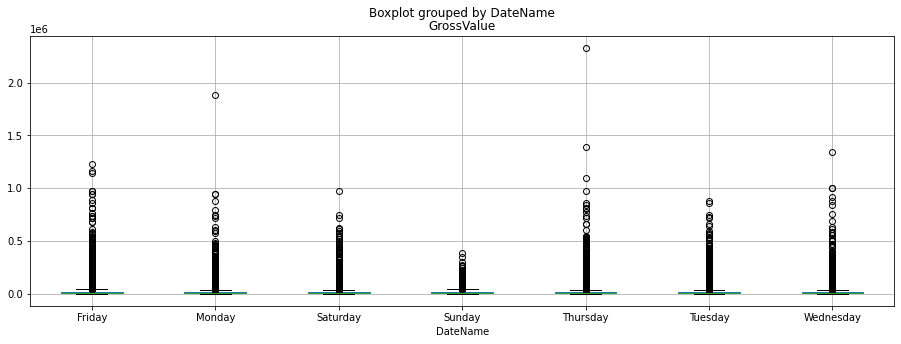

In [27]:
boxplot = Sale_by_invoice.boxplot(column=["GrossValue"],by="DateName")
boxplot.plot()

plt.show()

#### Discussion Points

* This shows that Friday had notable outliers to dominate total result

### Sales rep sales by week day

In [28]:
#group data
RepSale_by_invoice = Rep_invoice_All.groupby("ID").agg({'GrossValue':'sum' , 'DateName':'max' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
RepSale_by_invoice = RepSale_by_invoice.set_index("ID")
RepSale_by_invoice.sort_index(inplace=True)
RepSale_by_invoice.reset_index()

,ID,GrossValue,DateName,WeekDay
0,CSO007700410,6621.25,Tuesday,3
1,CSO007700411,3878.30,Tuesday,3
2,CSO007700412,22543.80,Tuesday,3
3,CSO007700413,6579.00,Tuesday,3
4,CSO007700414,2631.60,Tuesday,3
...,...,...,...,...
177964,CSO019500071,572.00,Monday,2
177965,CSO019500072,21250.60,Monday,2
177966,CSO019500073,7920.00,Monday,2
177967,CSO019500074,2910.00,Monday,2


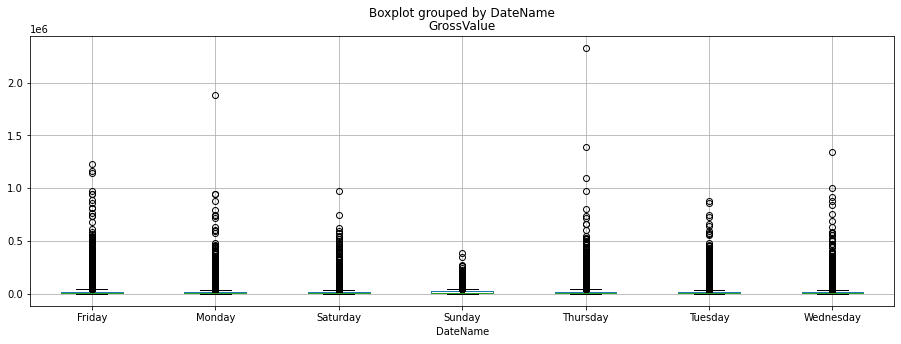

In [29]:
boxplot = RepSale_by_invoice.boxplot(column=["GrossValue"],by="DateName")
boxplot.plot()

plt.show()

#### Discussion Points

* This shows that Thursday/ Monday had notable outlier may dominate total result

### Head office and distributor sales by week day

In [30]:
#group data
AdminSale_by_invoice = Admin_invoice_All.groupby("ID").agg({'GrossValue':'sum' , 'DateName':'max' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
AdminSale_by_invoice = AdminSale_by_invoice.set_index("ID")
AdminSale_by_invoice.sort_index(inplace=True)
AdminSale_by_invoice.reset_index()

,ID,GrossValue,DateName,WeekDay
0,BO0081000081,711.0,Saturday,7
1,BO0081000107,5020.0,Tuesday,3
2,BO0081000146,1592.1,Tuesday,3
3,BO0081000147,3184.2,Tuesday,3
4,BO0081000148,7960.5,Tuesday,3
...,...,...,...,...
17036,IN0190000001,198425.6,Saturday,7
17037,IN0190000003,26797.5,Monday,2
17038,IN0190000005,18400.0,Wednesday,4
17039,IN0190000006,36766.0,Wednesday,4


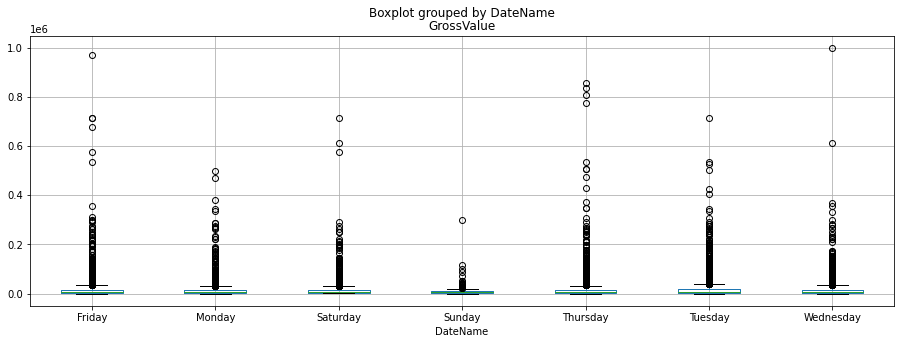

In [31]:
boxplot = AdminSale_by_invoice.boxplot(column=["GrossValue"],by="DateName")
boxplot.plot()

plt.show()

#### Discussion Points

* This shows that Friday had notable outlier may dominate total result

# Remove outliers - (z-score < 3)

### Total Sales by week day

In [32]:
Sale_by_invoice_z3 = Sale_by_invoice[(np.abs(stats.zscore(Sale_by_invoice["GrossValue"])) < 3)].reset_index()

In [33]:
Sale_by_invoice_z3.head(5)

,ID,GrossValue,DateName,WeekDay
0,BO0081000081,711.0,Saturday,7
1,BO0081000107,5020.0,Tuesday,3
2,BO0081000146,1592.1,Tuesday,3
3,BO0081000147,3184.2,Tuesday,3
4,BO0081000148,7960.5,Tuesday,3


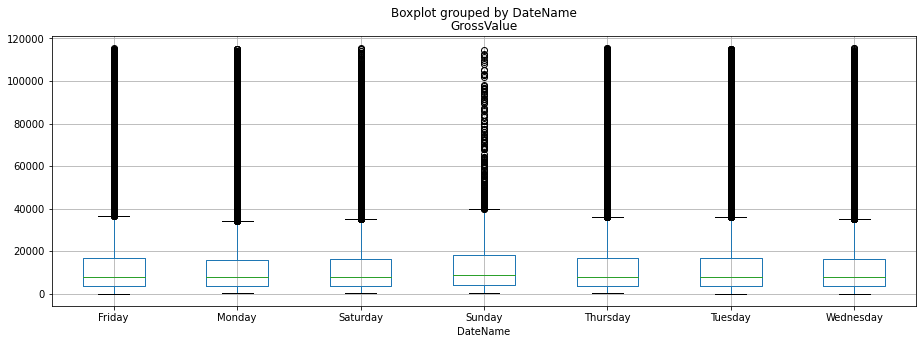

In [34]:
boxplot = Sale_by_invoice_z3.boxplot(column=["GrossValue"],by="DateName")
boxplot.plot()

plt.show()

### Sales rep sales by week day

In [35]:
RepSale_by_invoice_z3 = RepSale_by_invoice[(np.abs(stats.zscore(RepSale_by_invoice["GrossValue"])) < 3)].reset_index()

In [36]:
RepSale_by_invoice_z3.head(5)

,ID,GrossValue,DateName,WeekDay
0,CSO007700410,6621.25,Tuesday,3
1,CSO007700411,3878.30,Tuesday,3
2,CSO007700412,22543.80,Tuesday,3
3,CSO007700413,6579.00,Tuesday,3
4,CSO007700414,2631.60,Tuesday,3


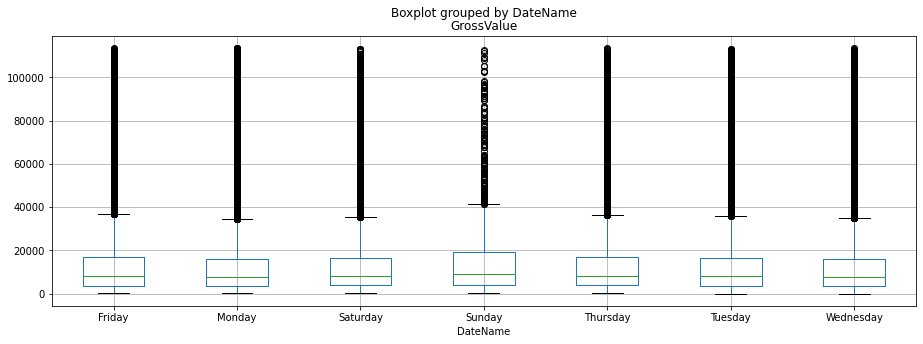

In [37]:
boxplot = RepSale_by_invoice_z3.boxplot(column=["GrossValue"],by="DateName")
boxplot.plot()

plt.show()

###  Head office and distributor sales by week day

In [38]:
AdminSale_by_invoice_z3 = AdminSale_by_invoice[(np.abs(stats.zscore(AdminSale_by_invoice["GrossValue"])) < 3)].reset_index()

In [39]:
AdminSale_by_invoice_z3.head(5)

,ID,GrossValue,DateName,WeekDay
0,BO0081000081,711.0,Saturday,7
1,BO0081000107,5020.0,Tuesday,3
2,BO0081000146,1592.1,Tuesday,3
3,BO0081000147,3184.2,Tuesday,3
4,BO0081000148,7960.5,Tuesday,3


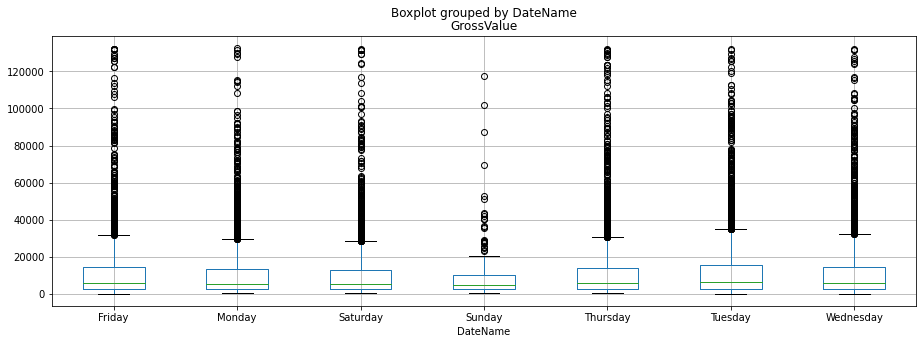

In [40]:
boxplot = AdminSale_by_invoice_z3.boxplot(column=["GrossValue"],by="DateName")
boxplot.plot()

plt.show()

### After removing outliers - Total Sales by week day

In [41]:
#group data
Week_Sales = Sale_by_invoice_z3.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,3.613027e+07
1,2,Monday,4.492711e+08
2,3,Tuesday,4.418297e+08
3,4,Wednesday,4.208546e+08
4,5,Thursday,4.839745e+08
5,6,Friday,4.632985e+08
6,7,Saturday,2.921752e+08


In [42]:
#group data
Week_invoices = Sale_by_invoice_z3.groupby("WeekDay")['ID'].nunique().reset_index()
Week_invoices = Week_invoices.set_index("WeekDay")
Week_invoices.sort_index(inplace=True)
Week_invoices.reset_index()

,WeekDay,ID
0,1,2459
1,2,34499
2,3,32346
3,4,32011
4,5,35236
5,6,33569
6,7,21935


In [43]:
Week_Sales_summary = pd.merge(Week_Sales,Week_invoices,  how = 'left' , left_on = ['WeekDay']  , right_on = ['WeekDay']).reset_index()
Week_Sales_summary.rename(columns={'ID':'NubOfInvoices'}, inplace=True)
Week_Sales_summary["AverageRevenue"] = Week_Sales_summary["GrossValue"] / Week_Sales_summary["NubOfInvoices"]
Week_Sales_summary = Week_Sales_summary.round({'AverageRevenue': 1})

In [44]:
Week_Sales_summary.head(7)

,WeekDay,DateName,GrossValue,NubOfInvoices,AverageRevenue
0,1,Sunday,3.613027e+07,2459,14693.1
1,2,Monday,4.492711e+08,34499,13022.7
2,3,Tuesday,4.418297e+08,32346,13659.5
3,4,Wednesday,4.208546e+08,32011,13147.2
4,5,Thursday,4.839745e+08,35236,13735.2
5,6,Friday,4.632985e+08,33569,13801.4
6,7,Saturday,2.921752e+08,21935,13320.0


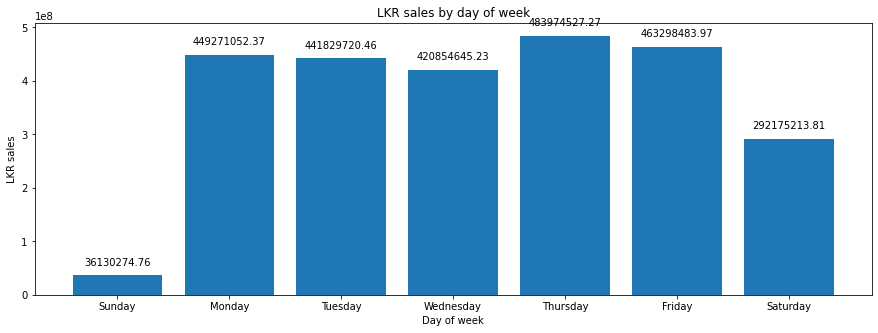

In [45]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("LKR sales by day of week")
plt.rcParams['figure.figsize'] = [15, 5]


# zip joins x and y coordinates in pairs
for x,y in zip(Week_Sales.DateName,Week_Sales.GrossValue):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    
plt.show()

### Discussion Points

* Above is total sales after removing outliers
* Now the highest sale day has change to Thursday which was Friday earlier.

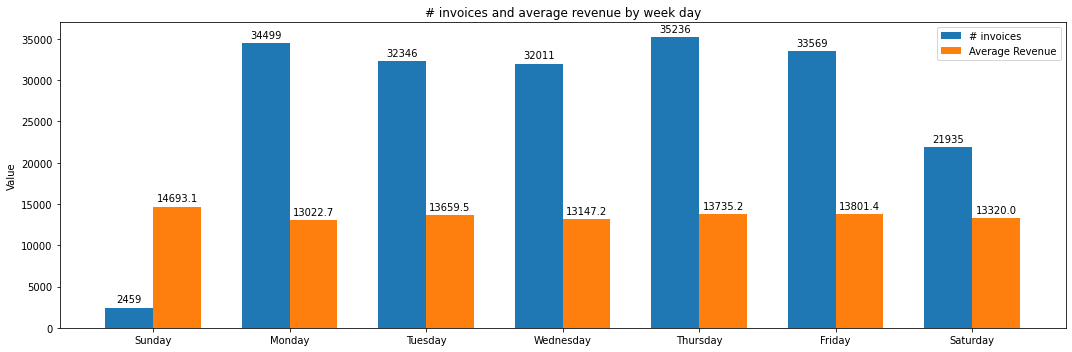

In [46]:
x = np.arange(len(Week_Sales_summary.DateName))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Week_Sales_summary.NubOfInvoices, width, label='# invoices')
rects2 = ax.bar(x + width/2, Week_Sales_summary.AverageRevenue, width, label='Average Revenue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('# invoices and average revenue by week day')
ax.set_xticks(x)
ax.set_xticklabels(Week_Sales_summary.DateName)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Discussion Points

* For the outlier removed data set try to identify number of invoices and average revenue per invoice
* Highest number of invoices were placed on Thursday and lowest were in Sunday
* Highest average revenue per invoice were recorded on Sunday although fewer number of invoices created
* Thursday and Friday has the next highest average revenue.

### After removing outliers - Sales rep sales by week day

In [47]:
#group data
Week_Sales = RepSale_by_invoice_z3.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,3.383927e+07
1,2,Monday,4.177634e+08
2,3,Tuesday,4.018248e+08
3,4,Wednesday,3.877117e+08
4,5,Thursday,4.502000e+08
5,6,Friday,4.273941e+08
6,7,Saturday,2.679828e+08


In [48]:
#group data
Week_invoices = RepSale_by_invoice_z3.groupby("WeekDay")['ID'].nunique().reset_index()
Week_invoices = Week_invoices.set_index("WeekDay")
Week_invoices.sort_index(inplace=True)
Week_invoices.reset_index()

,WeekDay,ID
0,1,2224
1,2,31735
2,3,29294
3,4,29286
4,5,32449
5,6,30604
6,7,19707


In [49]:
Week_Sales_summary = pd.merge(Week_Sales,Week_invoices,  how = 'left' , left_on = ['WeekDay']  , right_on = ['WeekDay']).reset_index()
Week_Sales_summary.rename(columns={'ID':'NubOfInvoices'}, inplace=True)
Week_Sales_summary["AverageRevenue"] = Week_Sales_summary["GrossValue"] / Week_Sales_summary["NubOfInvoices"]
Week_Sales_summary = Week_Sales_summary.round({'AverageRevenue': 1})

In [50]:
Week_Sales_summary.head(7)

,WeekDay,DateName,GrossValue,NubOfInvoices,AverageRevenue
0,1,Sunday,3.383927e+07,2224,15215.5
1,2,Monday,4.177634e+08,31735,13164.1
2,3,Tuesday,4.018248e+08,29294,13717.0
3,4,Wednesday,3.877117e+08,29286,13238.8
4,5,Thursday,4.502000e+08,32449,13874.1
5,6,Friday,4.273941e+08,30604,13965.3
6,7,Saturday,2.679828e+08,19707,13598.4


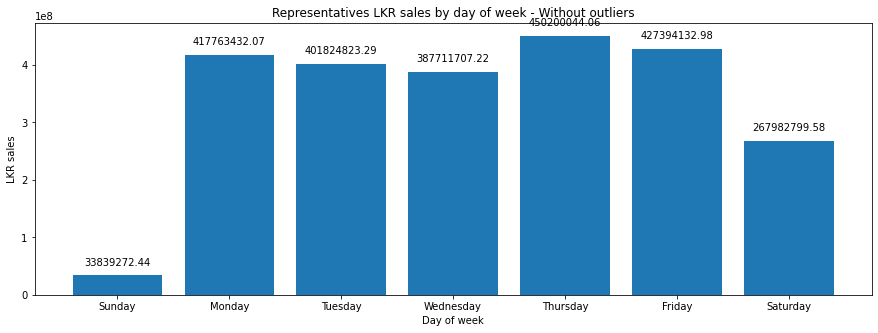

In [51]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("Representatives LKR sales by day of week - Without outliers")
plt.rcParams['figure.figsize'] = [15, 5]


# zip joins x and y coordinates in pairs
for x,y in zip(Week_Sales.DateName,Week_Sales.GrossValue):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    
plt.show()

### Discussion Points

* Above is rep sales after removing outliers
* Highest sale day is Thursday ( this was same with outliers as well)

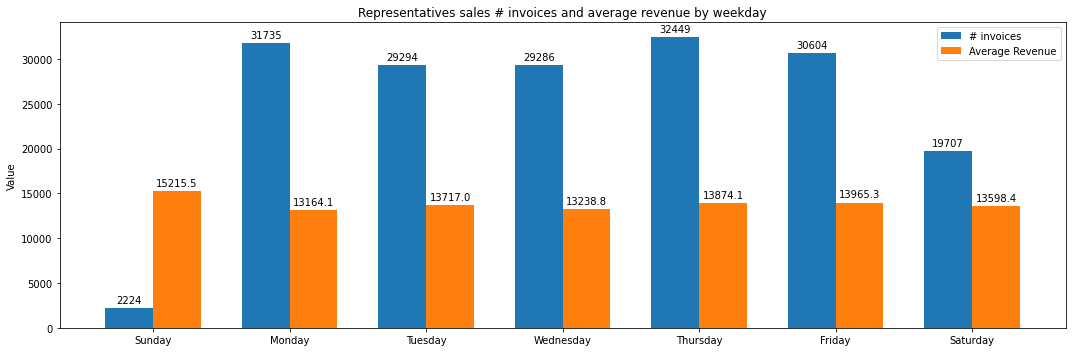

In [52]:
x = np.arange(len(Week_Sales_summary.DateName))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Week_Sales_summary.NubOfInvoices, width, label='# invoices')
rects2 = ax.bar(x + width/2, Week_Sales_summary.AverageRevenue, width, label='Average Revenue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Representatives sales # invoices and average revenue by weekday')
ax.set_xticks(x)
ax.set_xticklabels(Week_Sales_summary.DateName)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Discussion Points

* For the outlier removed data set ( Sales rep) try to identify number of invoices and average revenue per invoice
* Highest number of invoices were placed on Thursday and lowest were in Sunday
* Highest average revenue per invoice were recorded on Sunday although fewer number of invoices created
* Thursday and Friday has the next highest average revenue.

### After removing outliers - Head office and distributor sales by week day

In [53]:
#group data
Week_Sales = AdminSale_by_invoice_z3.groupby("DateName").agg({'GrossValue':'sum' , 'WeekDay':'max'}).reset_index()
# setting WeekDay as index column
Week_Sales = Week_Sales.set_index("WeekDay")
Week_Sales.sort_index(inplace=True)
Week_Sales.reset_index()

,WeekDay,DateName,GrossValue
0,1,Sunday,2293843.62
1,2,Monday,31472360.85
2,3,Tuesday,39890042.77
3,4,Wednesday,33713027.76
4,5,Thursday,34673358.40
5,6,Friday,36669916.74
6,7,Saturday,25015534.33


In [54]:
#group data
Week_invoices = AdminSale_by_invoice_z3.groupby("WeekDay")['ID'].nunique().reset_index()
Week_invoices = Week_invoices.set_index("WeekDay")
Week_invoices.sort_index(inplace=True)
Week_invoices.reset_index()

,WeekDay,ID
0,1,235
1,2,2763
2,3,3050
3,4,2729
4,5,2793
5,6,2970
6,7,2234


In [55]:
Week_Sales_summary = pd.merge(Week_Sales,Week_invoices,  how = 'left' , left_on = ['WeekDay']  , right_on = ['WeekDay']).reset_index()
Week_Sales_summary.rename(columns={'ID':'NubOfInvoices'}, inplace=True)
Week_Sales_summary["AverageRevenue"] = Week_Sales_summary["GrossValue"] / Week_Sales_summary["NubOfInvoices"]
Week_Sales_summary = Week_Sales_summary.round({'AverageRevenue': 1})

In [56]:
Week_Sales_summary.head(7)

,WeekDay,DateName,GrossValue,NubOfInvoices,AverageRevenue
0,1,Sunday,2293843.62,235,9761.0
1,2,Monday,31472360.85,2763,11390.6
2,3,Tuesday,39890042.77,3050,13078.7
3,4,Wednesday,33713027.76,2729,12353.6
4,5,Thursday,34673358.40,2793,12414.4
5,6,Friday,36669916.74,2970,12346.8
6,7,Saturday,25015534.33,2234,11197.6


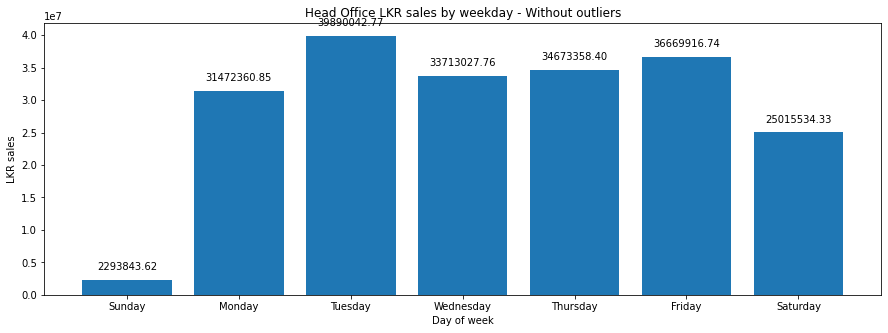

In [57]:
plt.bar(Week_Sales.DateName , Week_Sales.GrossValue)
plt.xlabel("Day of week")
plt.ylabel("LKR sales")
plt.title("Head Office LKR sales by weekday - Without outliers")
plt.rcParams['figure.figsize'] = [15, 5]


# zip joins x and y coordinates in pairs
for x,y in zip(Week_Sales.DateName,Week_Sales.GrossValue):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
    
plt.show()

### Discussion Points

* Above is Head office and distributor sales after removing outliers
* Highest sale day is Tuesday ( this was Friday with outliers )

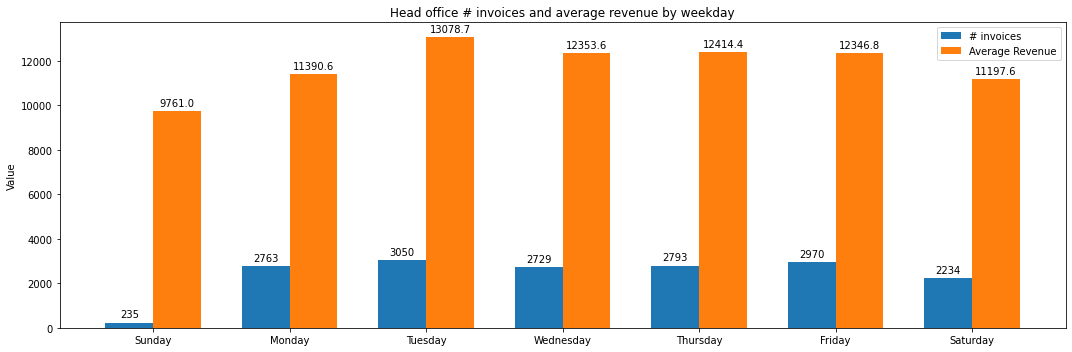

In [58]:
x = np.arange(len(Week_Sales_summary.DateName))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Week_Sales_summary.NubOfInvoices, width, label='# invoices')
rects2 = ax.bar(x + width/2, Week_Sales_summary.AverageRevenue, width, label='Average Revenue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Head office # invoices and average revenue by weekday')
ax.set_xticks(x)
ax.set_xticklabels(Week_Sales_summary.DateName)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Discussion Points

* For the outlier removed data set (Head office and distributor)try to identify number of invoices and average revenue per invoice
* Highest number of invoices were placed on Tuesday (Slightly higher from Friday) and lowest were in Sunday
* Highest average revenue per invoice were recorded on Tuesady - (This was Sunday with outliers)
* Thursday has the next highest average revenue. - (This was Friday with outliers)